In [ ]:
Por otro lado, si tengo un proyecto, por de RL. Quiero hacer algunos modelos del mundo para predecir la dinamica de los eventos de mouse y teclado,
asi como de la pantalla y la posicion del cursor. Luego, usarlos para entrenar politicas que traduscan las intrucciones textuales en acciones en la pc
(realizacion de tareas por agentes basados en LLMs y LVMS). 
Todo sto es mucho trabajo, asi que voy de poco en poco. 

* entrenar una lstm-mdn
* embbegins, vs one-hot encoding vs my normalization?
* Inclur embbedings para los eventos de mouse y keyboard
* Sustituir px,py por las acciones del raton  dx,dy e inlcirlas como tokens en el vocabularios

In [1]:
from monitorlib import load_pcdata
import pandas as pd

data = load_pcdata('data')

def sync_positions(data,sample,i):
     # Cursor positions
     ti = data[sample]['screenshots']['timestamp'][i]
     abs_diff = abs(data[sample]['moves']['timestamp'] - ti)
     closest_index = abs_diff.idxmin()
     px, py = data[sample]['moves']['px'][closest_index], data[sample]['moves']['py'][closest_index]
     return px, py

def sync_MKevents(sample_df, data, sample):
     
     def set_value(sample_df, abs_diff, event):
          closest_index = abs_diff.idxmin()
          if sample_df['mouse_keyboard'][closest_index] != None:
               print('colision')
               # what to do?
               sample_df.loc[closest_index, 'mouse_keyboard'] = event
          else:
               sample_df.loc[closest_index, 'mouse_keyboard'] = event
          

     # Initial values
     sample_df['mouse_keyboard'] = [None for i in range(len(sample_df))]
     timestamps_df = data[sample]['screenshots']['timestamp']

     # Clicks
     for i in range(len(data[sample]['clicks'])):
          ti = data[sample]['clicks']['timestamp'][i]
          button = data[sample]['clicks']['button'][i]
          set_value(sample_df, abs(timestamps_df - ti), button)

     # Scrolls
     for i in range(len(data[sample]['scrolls'])):
          ti = data[sample]['scrolls']['timestamp'][i]
          dy = data[sample]['scrolls']['dy'][i] 
          if dy == 1:
               scroll = 'scroll_down' 
          elif dy == -1:
               scroll = 'scroll_up'
          else:
               scroll = 'what?_scroll'
          set_value(sample_df, abs(timestamps_df - ti), scroll)
   
     # Keyboard events
     for i in range(len(data[sample]['keys'])):
          ti = data[sample]['keys']['timestamp'][i]
          key = data[sample]['keys']['key'][i].strip("'")
          set_value(sample_df, abs(timestamps_df - ti), key)

def sync(data):
     samples = []
     for sample in data.keys():
          sample_df = pd.DataFrame()
          sample_df['img_path'] = [img_path for img_path in data[sample]['screenshots']['img_path']]
          
          # Sync cursor positions to screenshots
          positions = [sync_positions(data,sample,i) for i in range(len(data[sample]['screenshots']))]
          sample_df['px'] = [px for px, _ in positions]
          sample_df['py'] = [py for _, py in positions]

          # Sync mouse and keyboard events to screenshots
          sync_MKevents(sample_df, data, sample)

          samples.append(sample_df)
     return samples


samples = sync(data)
samples[0]

,img_path,px,py,mouse_keyboard
0,data/sample1/0000000000_0.04096198081970215.jpg,570,428,None
1,data/sample1/0000000001_0.12202715873718262.jpg,570,428,None
2,data/sample1/0000000002_0.19535470008850098.jpg,570,428,None
3,data/sample1/0000000003_0.26665711402893066.jpg,570,428,None
4,data/sample1/0000000004_0.3381388187408447.jpg,570,428,None
...,...,...,...,...
726,data/sample1/0000000726_50.409887075424194.jpg,1360,300,None
727,data/sample1/0000000727_50.47743463516235.jpg,1360,300,None
728,data/sample1/0000000728_50.54669976234436.jpg,1360,300,None
729,data/sample1/0000000729_50.616905212402344.jpg,1360,300,None


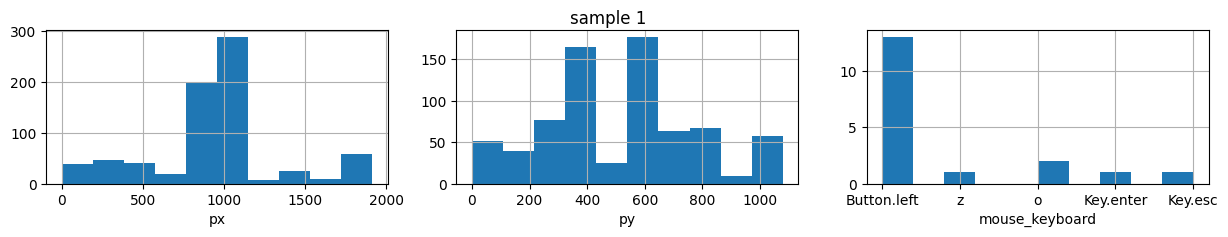

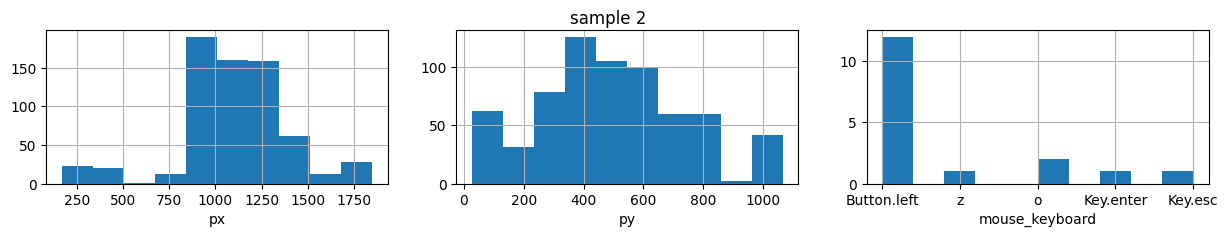

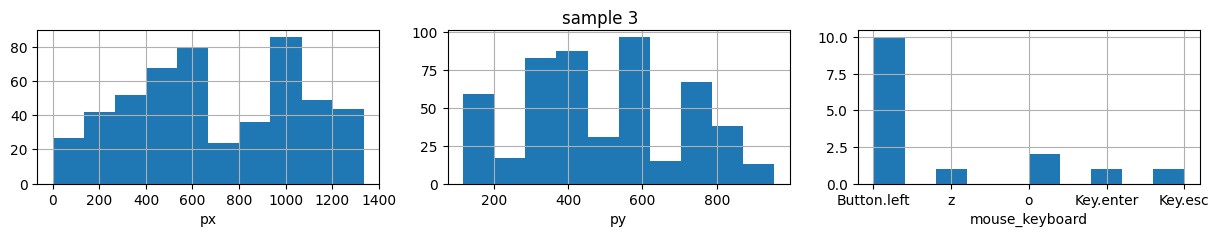

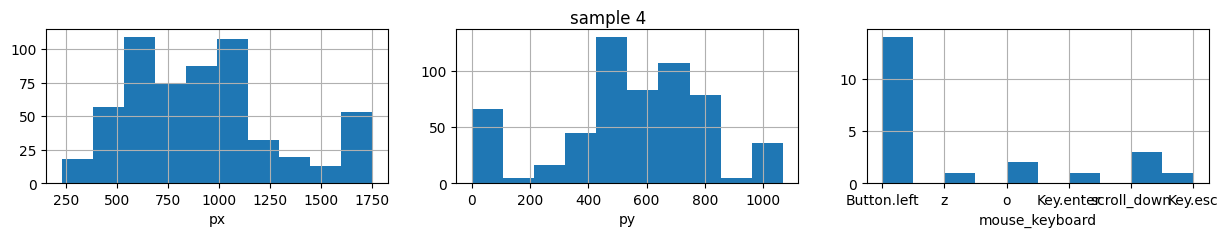

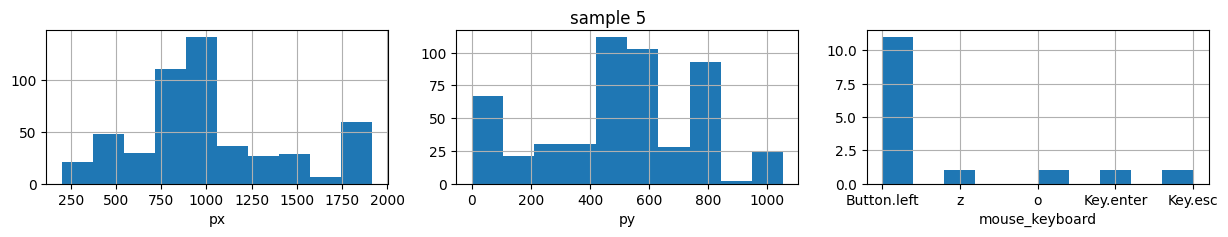

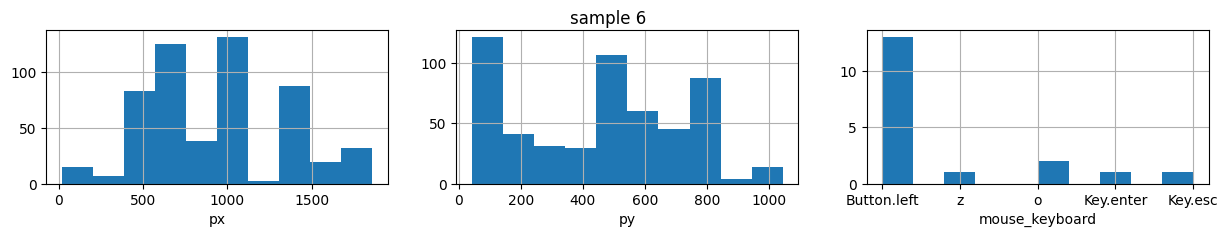

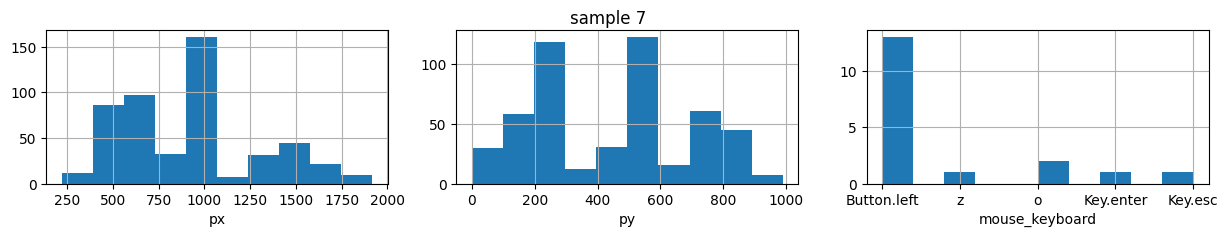

In [2]:
import matplotlib.pyplot as plt

for i, sample_df in enumerate(samples, 1):
    plt.figure(figsize=(15,2))
    plt.suptitle(f'sample {i}')
    for i,kname in enumerate(['px', 'py', 'mouse_keyboard']):
        plt.subplot(1,3,i+1)
        sample_df[kname].hist()
        plt.xlabel(kname)
    
    plt.plot()

In [3]:
# Replace None values with a string
for sample in samples:
    sample.fillna("no_action",inplace=True)

# tokenization
tokens = set()
for sample in samples:
    tokens.update(sample['mouse_keyboard'].unique().tolist())
tokens = list(tokens)
tokens.sort()
print(len(tokens))
print(tokens)

7
['Button.left', 'Key.enter', 'Key.esc', 'no_action', 'o', 'scroll_down', 'z']


In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super().__init__()
        self.conv1 = nn.Conv2d(3,32,4, stride=2, padding="valid")
        self.conv2 = nn.Conv2d(32,64,4, stride=2, padding="valid")
        self.conv3 = nn.Conv2d(64,128,4, stride=2, padding="valid")
        self.conv4 = nn.Conv2d(128,256,4, stride=2, padding="valid")
        self.fc_mean = nn.Linear(256*2*2, latent_dims)
        self.fc_logvar = nn.Linear(256*2*2, latent_dims)

        self.N = torch.distributions.normal.Normal(torch.tensor(0.0).to(device), 
                                                   torch.tensor(1.0).to(device))
        self.kl = 0
    
    def forward(self, x):
        #x = x.to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = torch.flatten(x, 1)
        z_mu = self.fc_mean(x)
        z_logvar = self.fc_logvar(x)
        z_sigma = torch.exp(0.5*z_logvar)
        
        z = z_mu + z_sigma*self.N.sample(z_mu.shape)
        self.kl = 0.5*(z_sigma**2 + z_mu**2 - z_logvar - 1).sum()
        return z, z_mu, z_sigma

class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Linear(latent_dims, 1024),
            nn.ReLU(True),
            nn.Unflatten(1,(1024,1,1)),
            nn.ConvTranspose2d(1024,128,5, stride=2, padding=0),
            nn.ReLU(True),
            nn.ConvTranspose2d(128,64,5, stride=2, padding=0),
            nn.ReLU(True),
            nn.ConvTranspose2d(64,32,6, stride=2, padding=0),
            nn.ReLU(True),
            nn.ConvTranspose2d(32,3,6, stride=2, padding=0),
            nn.Tanh(),
        )
    
    def forward(self, x):
        return self.decoder(x)

class Vae(nn.Module):
    def __init__(self, latent_dims):
        super().__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        # x = x.to(device)
        z, _, _ = self.encoder(x)
        return self.decoder(z)

import torch

SEED = 0
d = 32

torch.manual_seed(SEED)
# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# print(f'device: {device}')

device = "cpu"
vae = Vae(latent_dims=d)
vae.to(device)
vae.load_state_dict(torch.load('best_vae.pt')['model_state_dict'])
vae.eval()
vae.encoder

Encoder(
  (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=valid)
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=valid)
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=valid)
  (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=valid)
  (fc_mean): Linear(in_features=1024, out_features=32, bias=True)
  (fc_logvar): Linear(in_features=1024, out_features=32, bias=True)
)

In [5]:
from tqdm import tqdm
from PIL import Image
from torchvision import transforms

IMGSIZE= [64,64] #[1080//10, 1920//10]
img_transform = transforms.Compose([
                transforms.Resize(IMGSIZE, antialias=None),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                    std=[0.5, 0.5, 0.5]),
                
                ])

for sample in tqdm(samples): 
    zmu_list, zsigma_list = [], []
    for i, img_path in enumerate(sample["img_path"]):
        image = Image.open(img_path)
        image = img_transform(image)
        with torch.no_grad():
            _, zmu, zsigma = vae.encoder(torch.unsqueeze(image, 0))
        zmu_list.append(zmu[0].numpy())
        zsigma_list.append(zsigma[0].numpy())
    sample['mu'] = zmu_list
    sample['sigma'] = zsigma_list

/home/ezamorag/miniconda3/envs/automat/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 7/7 [00:51<00:00,  7.30s/it]


In [6]:
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision

def normalization(x, max):
    return 2.0*(x/max) - 1.0

class PCDataset(Dataset):
    def __init__(self, samples, root_dir, encoder, transform, tokens):
        self.samples = samples
        self.root_dir = root_dir
        self.transform = transform
        self.encoder = encoder
        self.tokens = tokens
        self.maxtokens = len(tokens)
        self.maxlength = None
        self.maxwidth_screenshoot = None
        self.maxheight_screenshoot = None
        self.N = torch.distributions.normal.Normal(torch.tensor(0.0), 
                                                   torch.tensor(1.0))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        features_list = []
        actions = []
        for i, img_path in enumerate(self.samples[idx]["img_path"]):
            # Image features
            z_mu = torch.tensor(self.samples[idx]["mu"][i])
            z_sigma = torch.tensor(self.samples[idx]["sigma"][i])
            img_features = z_mu #+ z_sigma*self.N.sample(z_mu.shape)

            # Cursor positions and Mouse-keyboars events
            px = self.samples[idx]["px"][i]
            py = self.samples[idx]["py"][i]
            other_features = [normalization(px, max=self.maxwidth_screenshoot), 
                              normalization(py, max=self.maxheight_screenshoot)]
            other_features = torch.tensor(other_features)
            features = torch.cat((img_features, other_features), 0)
            features_list.append(features)

            event = self.tokens.index(self.samples[idx]["mouse_keyboard"][i])
            actions.append(normalization(event, max=self.maxtokens))

        # Padding
        padding_dims = self.maxlength-len(features_list)
        features_list.extend(torch.zeros(torch.Size([padding_dims]) + features.shape))
        noaction_value = normalization(self.tokens.index('no_action'), max=self.maxtokens)
        actions.extend(padding_dims*[noaction_value])

        z = torch.stack(features_list, 0).type(torch.FloatTensor)
        a = torch.tensor(actions).type(torch.FloatTensor)

        return z[:-1,:],  a[1:, None]
    
t_batch_size = 5
dataset = PCDataset(samples, root_dir='./', encoder=vae.encoder, transform=img_transform, tokens=tokens)
dataset.maxlength = 800
dataset.maxwidth_screenshoot = 1920
dataset.maxheight_screenshoot = 1080
#m = len(dataset)
traindata, valdata = torch.utils.data.random_split(dataset,[5, 2])
trainloader = torch.utils.data.DataLoader(traindata, batch_size=t_batch_size, shuffle=True, num_workers=10)
valloader = torch.utils.data.DataLoader(valdata, batch_size=2, shuffle=False, num_workers=10)

In [7]:
x0,y0 = next(iter(valloader))
print(x0.shape, y0.shape)

torch.Size([2, 799, 34]) torch.Size([2, 799, 1])


In [36]:
import torch.nn.functional as F

class LSTM8(nn.Module):  
    def __init__(self, z_dim, h_dim, a_dim, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(z_dim, h_dim, num_layers=num_layers, batch_first=True)
        self.fc_out = nn.Linear(h_dim, a_dim)

    def forward(self, zt):
        yt, _ = self.lstm(zt)
        at = self.fc_out(yt) # output shape: (N, L, output_size)
        return at


In [37]:
f_loss = nn.MSELoss(reduction='sum')

def train_epoch(model, device, dataloader, optimizer):
    model.train()
    train_loss = 0.0
    for z0, a1 in dataloader: 
        z0 = z0.to(device)
        a1 = a1.to(device)
        a1_pred = model(z0)
        loss = f_loss(a1, a1_pred)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()
    return train_loss/len(dataloader.dataset)

def test_epoch(model, device, dataloader):
    model.eval()
    val_loss = 0.0
    with torch.no_grad(): 
        for z0, a1  in dataloader: 
            z0 = z0.to(device)
            a1 = a1.to(device)
            a1_pred = model(z0)
            loss = f_loss(a1, a1_pred)
            val_loss += loss.item()
    return val_loss/len(dataloader.dataset)

In [10]:
import wandb

wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ezamorag (cic_lab). Use `wandb login --relogin` to force relogin


True

In [39]:
# Training from scratch
SEED = 0
lr = 0.001
epoch0 = 0
num_epochs = 1200

torch.manual_seed(SEED)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'device: {device}')
model = LSTM8(z_dim=34, h_dim=256, num_layers=1, a_dim=1)
model.to(device)
optim = torch.optim.Adam(model.parameters(), lr=lr)
best_valloss = float('Inf')
path_bestmodel = 'best_lstm8.pt'

device: cuda


In [40]:
from IPython.display import clear_output

run = wandb.init(project="vae-pc", 
                 #name='2000 epochs', 
                 #entity='cic20',
                 mode="disabled", 
                 config={
                    "image_size": IMGSIZE,
                    "input_transform": img_transform, 
                    #"vae_latent_dims": d,
                    "learning_rate": lr,
                    "epochs": num_epochs,
                    "batch_size": trainloader.batch_size,
                    "seed": SEED, 
                 },
)
wandb.watch(model, log_freq=100)

trainloss, valloss = [], []
for epoch in range(epoch0, epoch0+num_epochs):
   trainloss.append(train_epoch(model,device,trainloader,optim))
   valloss.append(test_epoch(model,device,valloader))
   if valloss[-1] < best_valloss: 
      best_valloss = valloss[-1]
      torch.save({'epoch': epoch,
                  'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optim.state_dict(),
                  'trainloss': trainloss[-1],
                  'valloss': valloss[-1],},
                  path_bestmodel)
   print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,trainloss[-1],valloss[-1]))
   #clear_output(wait=True) if (epoch + 1) % 10 == 0 else None
   wandb.log({"t_loss": trainloss[-1], "v_loss": valloss[-1]})


 EPOCH 1/1200 	 train loss 27.204 	 val loss 17.953

 EPOCH 2/1200 	 train loss 19.214 	 val loss 12.778

 EPOCH 3/1200 	 train loss 13.841 	 val loss 10.141

 EPOCH 4/1200 	 train loss 11.101 	 val loss 10.358

 EPOCH 5/1200 	 train loss 11.312 	 val loss 11.749

 EPOCH 6/1200 	 train loss 12.801 	 val loss 11.734

 EPOCH 7/1200 	 train loss 12.865 	 val loss 10.854

 EPOCH 8/1200 	 train loss 11.972 	 val loss 10.058

 EPOCH 9/1200 	 train loss 11.099 	 val loss 9.676

 EPOCH 10/1200 	 train loss 10.623 	 val loss 9.655

 EPOCH 11/1200 	 train loss 10.522 	 val loss 9.828

 EPOCH 12/1200 	 train loss 10.641 	 val loss 10.043

 EPOCH 13/1200 	 train loss 10.827 	 val loss 10.203

 EPOCH 14/1200 	 train loss 10.973 	 val loss 10.266

 EPOCH 15/1200 	 train loss 11.033 	 val loss 10.234

 EPOCH 16/1200 	 train loss 11.003 	 val loss 10.130

 EPOCH 17/1200 	 train loss 10.903 	 val loss 9.985

 EPOCH 18/1200 	 train loss 10.768 	 val loss 9.831

 EPOCH 19/1200 	 train loss 10.628 	 val 

best val_loss = 9.45168685913086 at epoch = 150


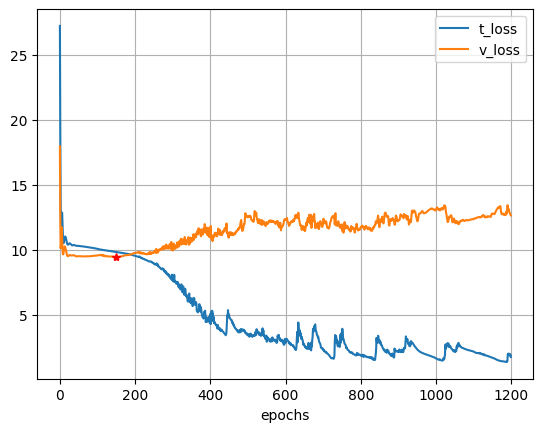

In [42]:
import numpy as np

ep_opt = np.argmin(np.asarray(valloss))
plt.plot(trainloss, label='t_loss')
plt.plot(valloss, label='v_loss')
plt.plot(ep_opt, valloss[ep_opt], 'r*')
plt.grid('on')
plt.xlabel('epochs')
plt.legend()
print(f'best val_loss = {valloss[ep_opt]} at epoch = {ep_opt}')
plt.show()

wandb.log({"best_val_loss": valloss[ep_opt], "best_epoch": ep_opt})

In [43]:
torch.save({'epoch': 1199,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
            'trainloss': trainloss[-1],
            'valloss': valloss[-1],},
            'best_lstm8_1layer_last.pt')

In [45]:
import numpy as np 

lstm_best = LSTM8(z_dim=34, h_dim=256, num_layers=1, a_dim=1)
lstm_best.to(device)
lstm_best.load_state_dict(torch.load('best_lstm8_1layer_last.pt')['model_state_dict'])

print(test_epoch(lstm_best,device,trainloader))


1.7590953826904296


Ground true


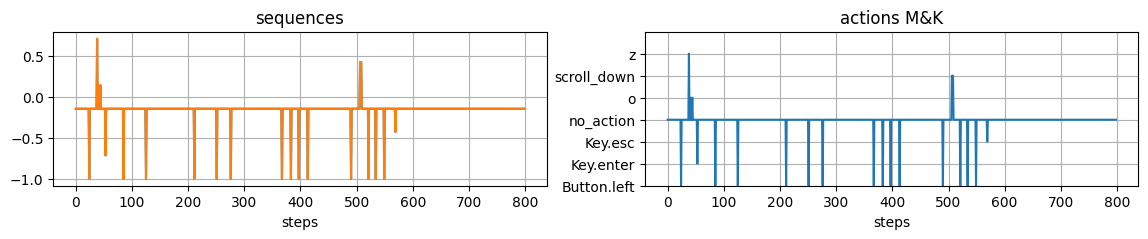

Predicted


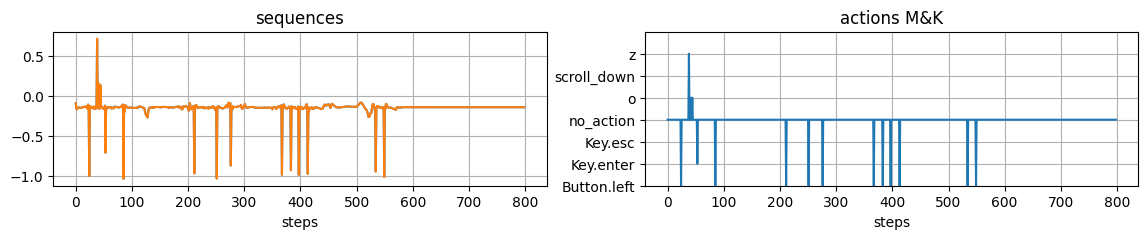

In [47]:
def unnormalized(xtensor):
    return np.transpose((xtensor*0.5+0.5).numpy(), (1, 2, 0))

def denormalization(x_norm, max):
    return max/2*(x_norm + 1.0)

def detransform(actions, max):
    actions = denormalization(actions, max)
    return np.round(actions).astype('uint8')

def viz(z):
    plt.figure(figsize=(14,2))
    plt.subplot(121)
    plt.plot(z)
    plt.title('sequences')
    plt.plot(z)
    plt.grid('on')
    plt.xlabel('steps')
    plt.subplot(122)
    plt.title('actions M&K')
    plt.plot(detransform(z, dataset.maxtokens))
    plt.ylim([0,dataset.maxtokens])
    plt.yticks(range(len(tokens)), tokens, rotation='horizontal')
    plt.grid('on')
    plt.xlabel('steps')
    plt.show()

with torch.no_grad():
    zbatch,abatch = next(iter(trainloader))
    
ib = 0
zbatch = zbatch.to(device)
abatch = abatch.to(device)
zout = lstm_best(zbatch)

print('Ground true')
viz(abatch[ib,:,:].squeeze().detach().cpu().numpy())
print('Predicted')
viz(zout[ib,:,:].squeeze().detach().cpu().numpy())


In [14]:
# Incompatibilidad: VAE produce rasgos entre [-4,4], pero la LSTM actual no generar valores fuera de [-1,1]

def visualization(z, ix_img):
    s = z[:,:32] 
    mx = denormalization(z[:,32], dataset.maxwidth_screenshoot)
    my = denormalization(z[:,33], dataset.maxheight_screenshoot)
    ac = detransform(z[:,34], dataset.maxtokens)

    plt.figure(figsize=(14,2))
    plt.subplot(141)
    plt.title('location')
    plt.plot(mx, my)
    plt.xlim([-100,2100])
    plt.ylim([-100,1200])
    plt.grid('on')
    plt.xlabel('steps')
    plt.subplot(142)
    plt.title('sequences')
    plt.plot(mx, label='mx')
    plt.plot(my, label='my')
    plt.legend()
    plt.grid('on')
    plt.xlabel('steps')
    plt.subplot(144)
    plt.title('actions M&K')
    plt.plot(ac)
    plt.ylim([0,dataset.maxtokens])
    plt.yticks(range(len(tokens)), tokens, rotation='horizontal')
    plt.grid('on')
    plt.xlabel('steps')
    plt.show()

    # Screen features
    stats = np.asarray([np.max(s, axis=1),np.min(s, axis=1),np.mean(s, axis=1),np.std(s, axis=1)])
    stats = stats.T
    plt.figure(figsize=(12,3.5))
    plt.suptitle('Screen features')
    plt.subplot(131)
    plt.title('max-mean-std-min')
    plt.plot(stats)
    plt.grid('on')
    plt.xlabel('steps')
    plt.subplot(132)
    plt.title('mean')
    plt.plot(stats[:,2])  
    plt.grid('on')
    plt.xlabel('steps')
    plt.subplot(133)
    plt.title('std')
    plt.plot(stats[:,3])
    plt.grid('on')
    plt.xlabel('steps')
    plt.show()

    latent = torch.Tensor(z[ix_img:ix_img+1,:32])
    img_recon = vae.decoder(latent.cpu())
    img_recon = img_recon.cpu()
    mosaic = torchvision.utils.make_grid(img_recon.data[:100],10,5)
    fig, ax = plt.subplots(figsize=(10, 3))
    plt.imshow(unnormalized(mosaic))
    plt.show()

def visualization_normalized(z):
    plt.figure(figsize=(14,2))
    plt.subplot(141)
    plt.title('location (normalized)')
    plt.plot(z[:,32], z[:,33])
    plt.grid('on')
    plt.xlabel('steps')
    plt.subplot(142)
    plt.title('sequences (normalized)')
    plt.plot(z[:,32], label='mx')
    plt.plot(z[:,33], label='my')
    plt.legend()
    plt.grid('on')
    plt.xlabel('steps')
    plt.subplot(144)
    plt.title('actions M&K (normalized)')
    plt.plot(z[:,34])
    plt.grid('on')
    plt.xlabel('steps')
    plt.show()


IMPORTANTE checar el rango de valors de salida de lstm conlos de entrenamiento